In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import uncertainties.unumpy as unp
import uncertainties as unc
from uncertainties.umath import log10
import scipy.integrate as integrate
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import PchipInterpolator

In [2]:
sol_rad = 6.957e10 #cm
c = 299792458 * 100 #cm/s
parsec = 3.08568e18 #cm
jansky = 1e-23

H0 = 67.4 # km s^-1 Mpc^-1
omega_m = 0.315
cosmos = FlatLambdaCDM(H0=H0, Om0=omega_m)

In [3]:
def madau_sfr(z):
    """
    Returns the star formation rate density at redshift z as determined by Madau and Dickinson (2014)
    """
    return 0.015 * (1+z)**2.7 / (1 + ((1+z)/2.9)**5.6)   # M_sun yr^-1 Mpc^-3

def madau17_sfr(z):
    """
    Returns the star formation rate density at redshift z as determined by Madau and Fragos (2017)
    """
    return 0.01 * (1+z)**2.6 / (1 + ((1+z)/3.2)**6.2)   # M_sun yr^-1 Mpc^-3

def bouwens_fitsfr(z):
    """
    Returns the star formation rate density using an exponential fit to the Bouwens et al. (2021) model
    as implemented in Bouwens et al. (2023) which utilizes the UV luminosity function integrated to 18 mag
    """
    return 10**(-1.19765496*np.exp(0.10745798*z))

### Generate an initial plot of SFRD from pre-JWST era

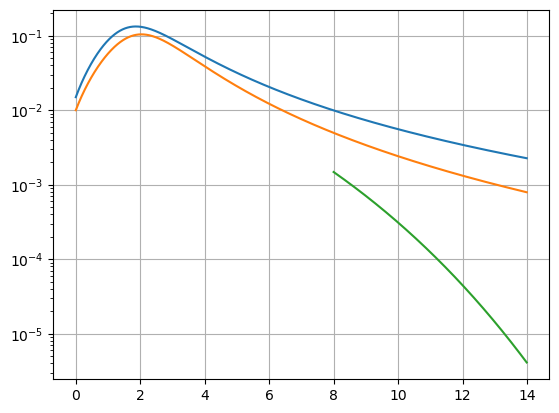

In [4]:
z = np.arange(0,14,0.01)
plt.plot(z, madau_sfr(z))
plt.plot(z, madau17_sfr(z))
plt.plot(z[800:], bouwens_fitsfr(z)[800:])
plt.yscale('log')
plt.grid()

### $\rm \mathcal{L} = \int L\; \phi(M)\; dM$

In [5]:
def dpl_mag(mag, phistar, magstar, alpha, beta):
    """
    Returns the double power law UV luminosity function given input in AB magnitude
    phistar: characteristic number density of galaxies
    magstar: characteristic magnitude at the knee of the function
    alpha: power law slope of the faint end
    beta: power law slope of the bright end
    """
    return phistar / (np.power(10, 0.4*(alpha+1)*(mag - magstar)) + np.power(10, 0.4*(beta+1)*(mag - magstar)))

def rho_uv(mags, phistar, magstar, alpha, beta, z):
    """
    Returns the UV luminosity density using the integral of the DPL UV LF and cosmological parameters.
    DPL function and parameters are defined in the function: dpl_mag()
    """
    def integrand(mag):
        L = np.power(10, -0.4 * mag)
        phi_M = phistar / (np.power(10, 0.4*(alpha+1)*(mag - magstar)) + np.power(10, 0.4*(beta+1)*(mag - magstar)))
        return L * phi_M
    integrand_arr = integrand(mags)
    wrapped_simpson = unc.wrap(integrate.simpson)
    # integral, abserr = integrate.quad(integrand, -23, faintmag)
    integral = wrapped_simpson(integrand_arr, mags)
    dl = cosmos.luminosity_distance(z).value * 1e6 # pc
    distmod = 5. * np.log10(dl / np.sqrt(1+z) / 10)
    rhouv = np.power(10, -0.4 * (-2.5 * log10(integral) + distmod + 48.6)) * 4. * np.pi * (dl * parsec)**2 / (1+z)
    return rhouv

def rho_uv_dustcorr(mags, phistar, magstar, alpha, beta, Auv, z):
    """
    Returns the dust-accounted UV luminosity density using the integral of the dust-accounted DPL UV LF and cosmological parameters.
    Takes the dust-accounted UVLF as input
    """
    def integrand(mag):
        L = np.power(10, -0.4 * (mag-Auv))
        phi_M = phistar / (np.power(10, 0.4*(alpha+1)*(mag - magstar)) + np.power(10, 0.4*(beta+1)*(mag - magstar)))
        return L * phi_M
    mags_corr = mags - Auv
    integrand_arr = integrand(mags)
    wrapped_simpson = unc.wrap(integrate.simpson)
    integral = wrapped_simpson(integrand_arr, mags_corr)
    dl = cosmos.luminosity_distance(z).value * 1e6 # pc
    distmod = 5. * np.log10(dl / np.sqrt(1+z) / 10)
    rhouv = np.power(10, -0.4 * (-2.5 * log10(integral) + distmod + 48.6)) * 4. * np.pi * (dl * parsec)**2 / (1+z)
    return rhouv

In [6]:
def schechter_mag(mag, phistar, magstar, alpha):
    """
    Returns the Schechter UV luminosity function given input in AB magnitude
    phistar: characteristic number density of galaxies
    magstar: characteristic magnitude at the knee of the function
    alpha: power law slope of the faint end
    """
    return 0.4 * np.log(10) * phistar * np.power(10, -0.4 * (mag - magstar) * (alpha + 1)) * np.exp(-np.power(10,-0.4 * (mag-magstar)))

def rho_uvsch(phistar, magstar, alpha, z, faintmag):
    """
    Returns the UV luminosity density using the integral of the Schechter UV LF and cosmological parameters.
    Schechter function and parameters are defined in the function: schechter_mag()
    """
    def integrand(mag):
        L = np.power(10, -0.4 * mag)
        phi_M = 0.4 * np.log(10) * phistar * np.power(10, -0.4 * (mag - magstar) * (alpha + 1)) * np.exp(-np.power(10,-0.4 * (mag-magstar)))
        return L * phi_M
    integral, abserr = integrate.quad(integrand, -23, faintmag)
    dl = cosmos.luminosity_distance(z).value * 1e6 # pc
    distmod = 5. * np.log10(dl / np.sqrt(1+z) / 10)
    rhouv = np.power(10, -0.4 * (-2.5 * np.log10(integral) + distmod + 48.6)) * 4. * np.pi * (dl * parsec)**2 / (1+z)
    return rhouv

### Perform the dust correction as done by Finkelstein (2016): using $M_{UV}-\beta$ relationship from Bouwens+2014 but using the $A_{UV}-\beta$ fit using GALEX+AKARI from Takeuchi et al. (2012), which gives us
$$
A_{1600} = 3.06 + 1.58\beta
$$
### Useful relation between $M_{UV}$ and $A_{UV}$ for calculating UV luminsotiy density: https://astronomy.stackexchange.com/questions/39806/relation-between-absolute-magnitude-of-uv-and-star-formation-rate, but see notes

Text(0.5, 0, '$z$')

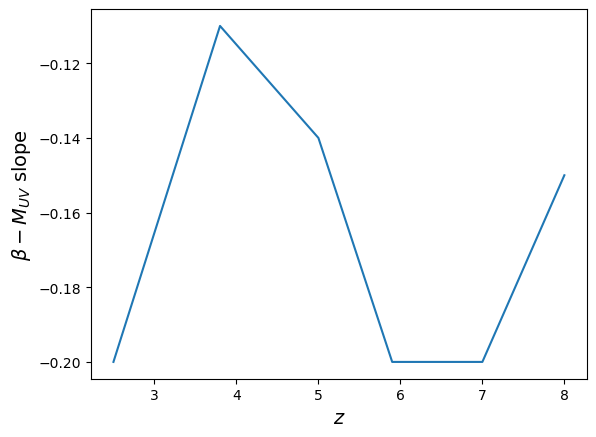

In [8]:
def beta_Muv_fit(mag, m, beta0, mag0=-19.5):
    return m*(mag-mag0) + beta0

def meurer_Auv(beta):
    return 3.06 + 1.58*beta

dustbeta0 = np.array([-1.7, -1.85, -1.91, -2, -2.05, -2.13])
betaMuv_slope = np.array([-0.2, -0.11, -0.14, -0.20, -0.20, -0.15])
dust_z = np.array([2.5, 3.8, 5.0, 5.9, 7.0, 8.0])
cs_dustbeta0 = PchipInterpolator(dust_z, dustbeta0)

plt.plot(dust_z, betaMuv_slope)
plt.ylabel(r'$\beta-M_{UV}$ slope', fontsize=14)
plt.xlabel(r'$z$', fontsize=14)

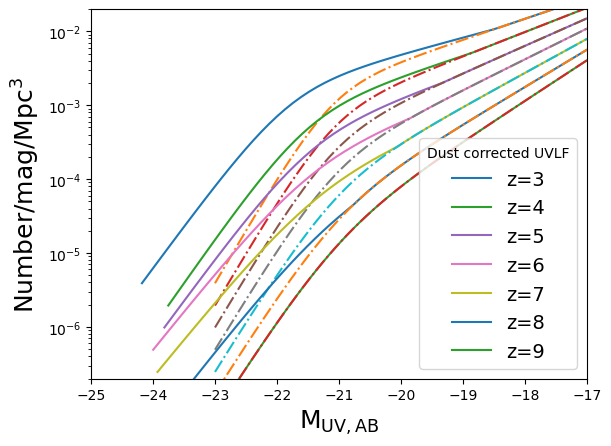

In [11]:
z_fink22 = [3,4,5,6,7,8,9]
phistar_fink22 = 10**unp.uarray([-2.72, -3.03, -3.35, -3.66, -3.97, -4.29, -4.6], [0.08, 0.07, 0.06, 0.08, 0.12, 0.17, 0.21])
magstar_fink22 = unp.uarray([-21.13, -21.11, -21.1, -21.08, -21.06, -21.05, -21.03], [0.09, 0.07, 0.07, 0.09, 0.13, 0.16, 0.2])
alpha_fink22 = unp.uarray([-1.71, -1.82, -1.93, -2.04, -2.15, -2.26, -2.37], [0.04, 0.03, 0.03, 0.04, 0.05, 0.06, 0.08])
beta_fink22 = unp.uarray([-4.59, -4.54, -4.49, -4.44, -4.39, -4.33, -4.28], [0.16, 0.12, 0.1, 0.11, 0.13, 0.17, 0.22])

dustbeta0_sm = cs_dustbeta0(z_fink22[:-1])
betaMuv_sm = np.interp(z_fink22[:-1], dust_z, betaMuv_slope)

mags = np.linspace(-23, -17, 60)
Auv = np.zeros((len(z_fink22), mags.shape[0]))
for i in range(len(z_fink22)):
    if i < len(z_fink22)-1:
        dustbeta = beta_Muv_fit(mags, betaMuv_sm[i], dustbeta0_sm[i])
        Auv[i] = meurer_Auv(dustbeta)
        Auv[i] = np.where(Auv[i]<0, 0, Auv[i])
    uvlf = dpl_mag(mags, phistar_fink22[i], magstar_fink22[i], alpha_fink22[i], beta_fink22[i])
    plt.plot(mags-Auv[i], unp.nominal_values(uvlf), label="z={}".format(z_fink22[i]))
    plt.plot(mags, unp.nominal_values(uvlf), ls='-.')

plt.yscale('log')
plt.ylim([2e-7, 2e-2])
plt.xlim([-25, -17])
plt.ylabel(r"Number/mag/Mpc$^3$", fontsize=18)
plt.xlabel(r"M$_{\rm UV, AB}$", fontsize=18)
plt.legend(title="Dust corrected UVLF", fontsize=14)
plt.show()

In [13]:
## SFRD evolution from Donnan et al. (2022)
z_don22 = np.linspace(8,13,35)
sfrd_don22 = 10**(-0.231*z_don22 + 27.5) * 1.15e-28

In [12]:
## Best-fit DPL parameters from this study (Gupta et al. 2025) 
z_omg25 = [9, 10.5, 12.5]
phistar_omg25 = 10**unp.uarray([-4.55, -4.80, -5.48], [0.43, 0.53, 0.22])
magstar_omg25 = unp.uarray([-20.81, -20.84, -20.83], [0.53, 0.71, 0.1])
alpha_omg25 = unp.uarray([-2.34, -2.25, -2.47], [0.17, 0.25, 0.32])
beta_omg25 = unp.uarray([-5.02, -5.01, -5.01], [1.19, 0.1, 0.1])

### Convert all UV luminosity densities to SFRDs using the same $\kappa_{UV} = 1.15\times10^{-28}$ for a Salpeter IMF (Madau & Dickinson 2014). Only Finkelstein (2016) values are dust-corrected.

In [15]:
sfrd_fink22 = []
# dust_fink22 = []
for i in range(len(z_fink22)):
    # number = rho_uv(phistar_fink22[i], magstar_fink22[i], alpha_fink22[i], beta_fink22[i], z_fink22[i], -17) * 1.15e-28
    number_corr = rho_uv_dustcorr(mags, phistar_fink22[i], magstar_fink22[i], alpha_fink22[i], beta_fink22[i], Auv[i], z_fink22[i]) * 1.15e-28
    # dust_fink22.append(number_corr/number)
    sfrd_fink22.append(number_corr)
    
sfrd_omg25 = []
rhouv_omg25 = []
for i in range(3):
    rho = rho_uv(mags, phistar_omg25[i], magstar_omg25[i], alpha_omg25[i], beta_omg25[i], z_omg25[i])
    number = rho * 1.15e-28
    rhouv_omg25.append(log10(rho))
    sfrd_omg25.append(number)

print(rhouv_omg25)

[25.272207317274983+/-0.5555595519911053, 24.960055412468005+/-0.7020404738743877, 24.47572369844485+/-0.38401489734223837]


In [17]:
## Data from Madau and Dickinson (2014)
z_md14 = np.array([0.05, 0.3, 0.5, 0.7, 1.0, 0.05, 0.125, 0.3, 0.5, 0.7, 0.9, 1.1, 1.45, 2.1, 3, 4, 1.125, 1.75, 2.225, 2.3, 3.05, 3.8, 4.9, 5.9, 7, 7.9, 7, 0.03, 0.03, 0.55, 0.85, 1.15, 1.55, 2.05, 0.55, 0.85, 1.15, 1.55, 2.05, 0.15, 0.375, 0.525, 0.7, 0.9, 1.1, 1.45, 1.85, 2.25, 2.75, 3.6])
lsfrd_md14 = np.array([-1.82, -1.5, -1.39, -1.2, -1.25, -1.77, -1.75, -1.55, -1.44, -1.24, -0.99, -0.94, -0.95, -0.75, -1.04, -1.69, -1.02, -0.75, -0.87, -0.75, -0.97, -1.29, -1.42, -1.65, -1.79, -2.09, -2, -1.72, -1.95, -1.34, -0.96, -0.89, -0.91, -0.89, -1.22, -1.1, -0.96, -0.94, -0.8, -1.64, -1.42, -1.32, -1.14, -0.94, -0.81, -0.84, -0.86, -0.91, -0.86, -1.36])
## Select only data points below redshift 4
lsfrd_md14 = lsfrd_md14[z_md14 < 4]
z_md14 = z_md14[z_md14 < 4]

In [19]:
## Combine all relevant data
all_z = np.concatenate((z_md14, z_fink22, z_omg25))
all_lsfrd = np.concatenate((lsfrd_md14, np.log10(unp.nominal_values(sfrd_fink22)), np.log10(unp.nominal_values(sfrd_omg25))))
## Select only data points below redshift 4
z04 = all_z[all_z <= 4]
lsfrd_z04 = all_lsfrd[all_z <= 4]

### Fit data at z < 4, with primary choice being Maximum Likelihood Estimation instead of scipy.curve_fit

In [20]:
def mysfrd_fit(z, a, b, alpha, beta):
    return np.log10(a * (1+z)**alpha / (1 + ((1+z)/b)**beta))

popt, pcov = curve_fit(mysfrd_fit, z04, lsfrd_z04, p0=[0.015, 2.9, 2.7, 5.6])
print(popt, np.sum(np.diag(pcov)))

def log_likelihood(theta, x, y):
    a, b, alpha, beta, log_f = theta
    model = mysfrd_fit(x, a, b, alpha, beta)
    residual = model - y
    sigma2 = model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

nll = lambda *args: -log_likelihood(*args)
initial = np.array([0.015, 2.9, 2.7, 5.6, np.log10(0.99)])
soln_z04 = minimize(nll, initial, args=(z04, lsfrd_z04))
print(soln_z04.x)

[0.01406758 2.91616469 2.90129161 6.30810101] 0.20707846655205114
[ 0.01521916  3.00410646  2.7322261   6.24077008 -2.55311895]


### Fit the data at z > 4, with a straight line in log-linear space with scipy.curve_fit

In [21]:
def lsfrd_line(z, m, c):
    return m*z + c

z_413 = all_z[all_z > 4]
lsfrd_z413 = all_lsfrd[all_z > 4]
popt1, pcov1 = curve_fit(lsfrd_line, z_413, lsfrd_z413)
print(popt1)

[-0.2571395  -0.27491379]


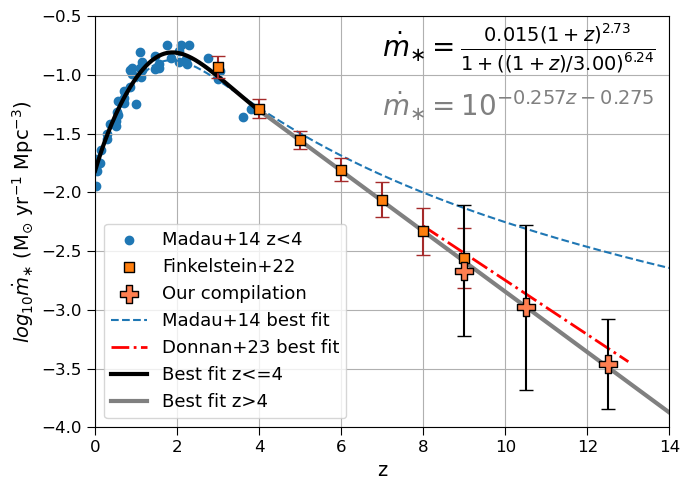

In [23]:
plt.figure(figsize=(7,5))
plt.scatter(z_md14, lsfrd_md14, label="Madau+14 z<4", marker='o', color='C0')
plt.scatter(z_fink22, np.log10(unp.nominal_values(sfrd_fink22)), 50, label="Finkelstein+22", zorder=10, marker='s', color='C1', edgecolor='black')
plt.errorbar(z_fink22, np.log10(unp.nominal_values(sfrd_fink22)), yerr=unp.std_devs([unc.umath.log10(sfrd_fink22[i]) for i in range(len(z_fink22))]), fmt='.', capsize=5, color='brown', zorder=9)
plt.scatter(z_omg25, np.log10(unp.nominal_values(sfrd_omg25)), 150, label="Our compilation", zorder=10, marker='P', color='coral', edgecolor='black')
plt.errorbar(z_omg25, np.log10(unp.nominal_values(sfrd_omg25)), yerr=unp.std_devs([unc.umath.log10(sfrd_omg25[i]) for i in range(0,3)]), fmt='.', capsize=5, color='black', zorder=9)
plt.plot(z, np.log10(madau_sfr(z)), label="Madau+14 best fit", color='C0', linestyle="--")
plt.plot(z_don22, np.log10(sfrd_don22), label="Donnan+23 best fit", linewidth=2, color='red', linestyle="-.")
plt.plot(z[:400], mysfrd_fit(z[:400], *soln_z04.x[:-1]), linewidth=3, color='k', label="Best fit z<=4")
plt.plot(z[401:], lsfrd_line(z[401:], *popt1), linewidth=3, color='gray', label="Best fit z>4")
# plt.yscale('log')
plt.text(7, -0.84, r"$\dot{m}_{\ast}=\frac{0.015 (1+z)^{2.73}}{1 + ((1+z)/3.00)^{6.24}}$", fontsize=20, color='k')
plt.text(7, -1.35, r"$\dot{m}_{\ast} = 10^{-0.257z - 0.275}$", fontsize=20, color='gray')
plt.legend(fontsize=13)
plt.ylabel(r"$log_{10} \dot{m}_{\ast}$ (M$_{\odot}$ yr$^{-1}$ Mpc$^{-3}$)", fontsize=14) 
plt.xlabel("z", fontsize=14)
plt.ylim([-4, -0.5])
plt.xlim([0,14])
plt.gca().tick_params(axis='both', which='major', length=6, labelsize=12)
plt.grid()
plt.tight_layout()
plt.show()

In [266]:
unp.std_devs([unc.umath.log10(sfrd_omg25[i]) for i in range(0,3)])

array([0.5528622 , 0.72540277, 0.45803882])